In [2]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

from utils2 import Logger

### Import dataset

In [3]:
batch_size_train = 100

data_dir = 'data/'

image_loader = torch.utils.data.DataLoader(
  datasets.MNIST(data_dir, train=True, download=True,
                             transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((.5), (.5))
                             ])),
  batch_size=batch_size_train, shuffle=True)

# Num batches
num_batches = len(image_loader)

In [50]:
tensor_test = torch.rand(100)

linear1 = nn.Linear(100, 200)
linear2 = nn.Linear(200, 350)

conv1 = nn.ConvTranspose2d(10, 1, kernel_size=14)
conv2 = nn.ConvTranspose2d(1, 1, kernel_size=3)

out = linear1(tensor_test)
out = linear2(out)
out = out.view(1, 10, 1, 35)
#out = torch.rand(1 , 10, 1, 1)
out = conv1(out)
out = conv2(out)
out.shape

torch.Size([1, 1, 16, 50])

### Defining networks

In [80]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    

In [81]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    

### Helper functions

In [72]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

### Training

In [118]:
#check if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [119]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

generator.to(device)
discriminator.to(device)

#Define loss function and both optimizer functions
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
loss = nn.BCELoss()

In [120]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N).to(device) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N).to(device))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [121]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    #Send data to device
    fake_data = fake_data.to(device)
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N).to(device))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [122]:
num_test_samples = 16
test_noise = noise(num_test_samples).to(device)

In [123]:
#bla = enumerate(image_loader)
#batch_idx, (example_data, example_targets) = next(bla)
#plt.imshow(example_data[0][0], cmap='gray', interpolation='none')

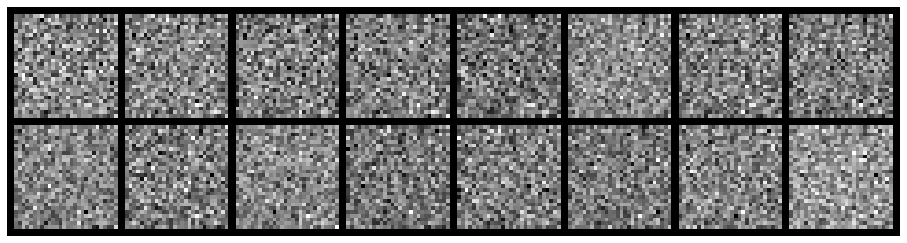

Epoch: [0/50], Batch Num: [0/600]
Discriminator Loss: 1.3910, Generator Loss: 0.7190
D(x): 0.4852, D(G(z)): 0.4869


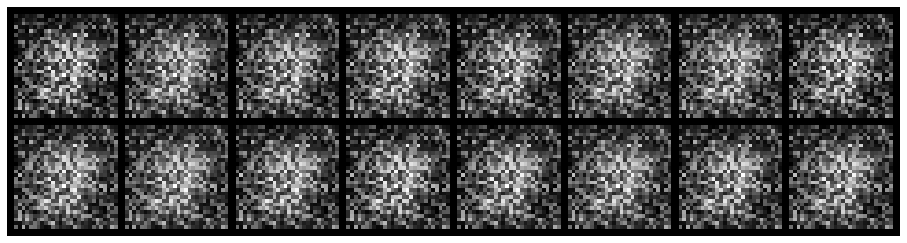

Epoch: [0/50], Batch Num: [100/600]
Discriminator Loss: 0.8323, Generator Loss: 2.7828
D(x): 0.6910, D(G(z)): 0.1713


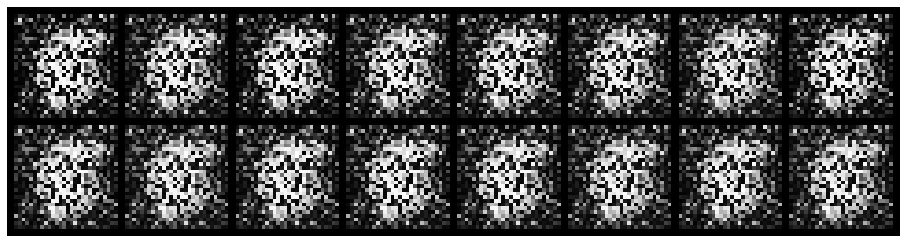

Epoch: [0/50], Batch Num: [200/600]
Discriminator Loss: 0.5737, Generator Loss: 2.8628
D(x): 0.9236, D(G(z)): 0.3476


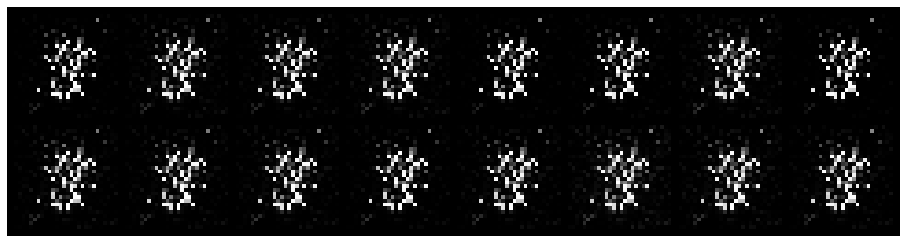

Epoch: [0/50], Batch Num: [300/600]
Discriminator Loss: 0.2431, Generator Loss: 3.2044
D(x): 0.8973, D(G(z)): 0.1083


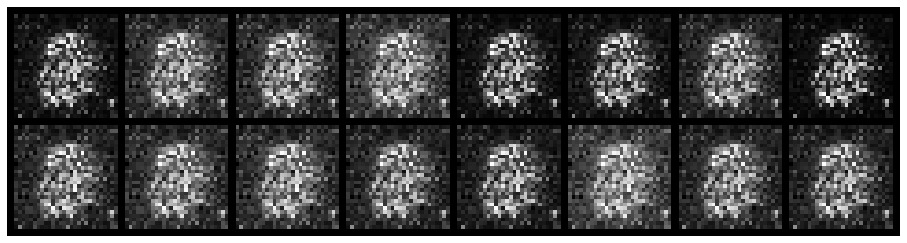

Epoch: [0/50], Batch Num: [400/600]
Discriminator Loss: 0.7533, Generator Loss: 3.5732
D(x): 0.6890, D(G(z)): 0.1173


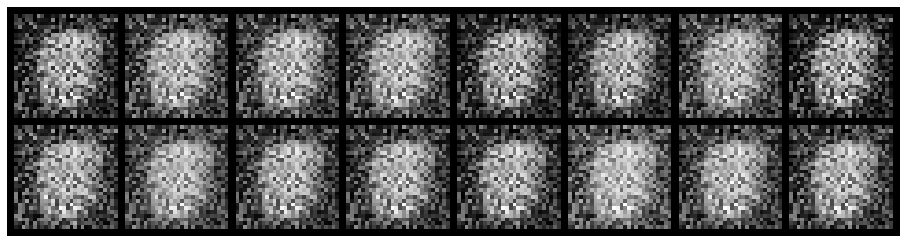

Epoch: [0/50], Batch Num: [500/600]
Discriminator Loss: 1.9317, Generator Loss: 0.6076
D(x): 0.6188, D(G(z)): 0.7230


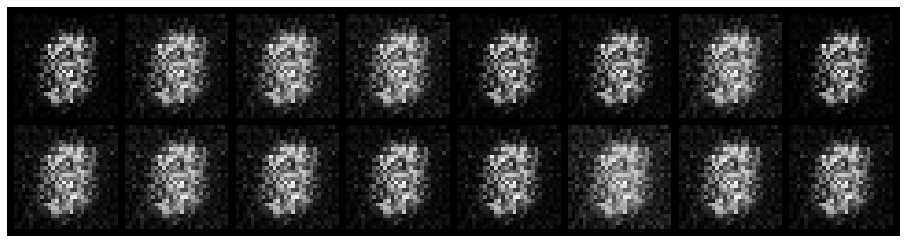

Epoch: [1/50], Batch Num: [0/600]
Discriminator Loss: 0.7096, Generator Loss: 1.7281
D(x): 0.7268, D(G(z)): 0.2870


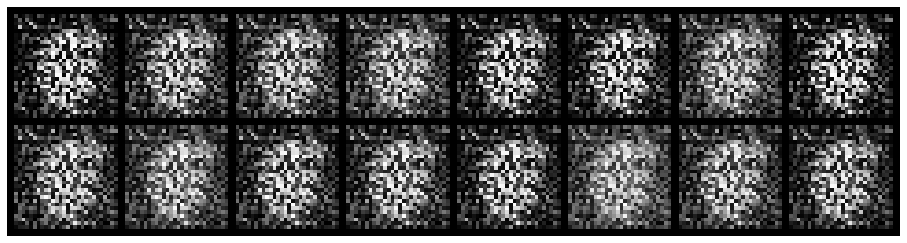

Epoch: [1/50], Batch Num: [100/600]
Discriminator Loss: 0.4108, Generator Loss: 5.3341
D(x): 0.8330, D(G(z)): 0.1589


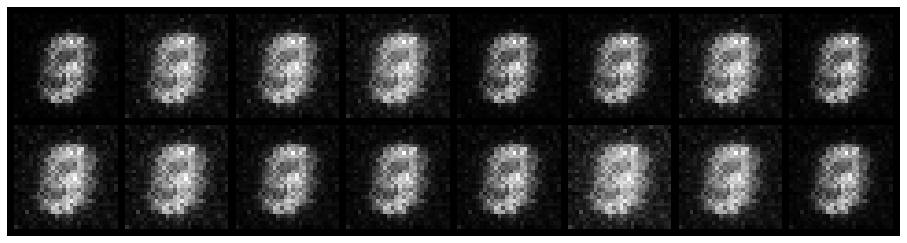

Epoch: [1/50], Batch Num: [200/600]
Discriminator Loss: 1.4435, Generator Loss: 1.0144
D(x): 0.5647, D(G(z)): 0.4747


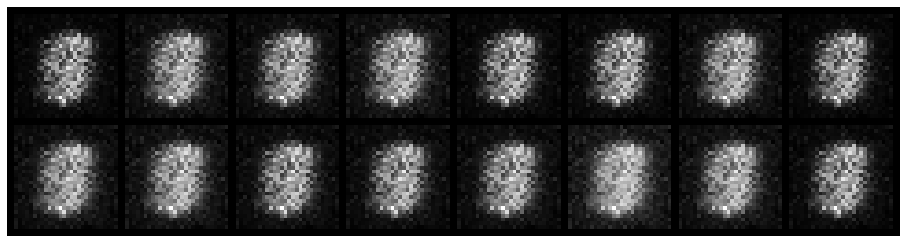

Epoch: [1/50], Batch Num: [300/600]
Discriminator Loss: 1.1276, Generator Loss: 0.8777
D(x): 0.6887, D(G(z)): 0.4767


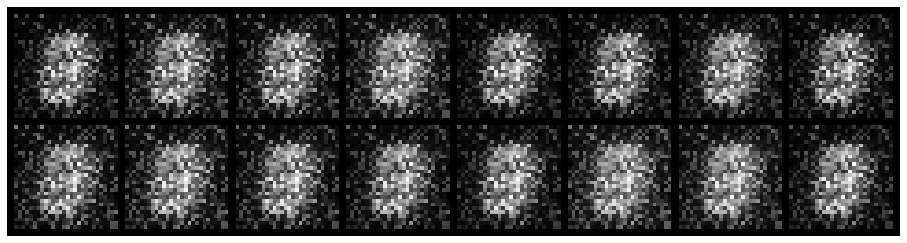

Epoch: [1/50], Batch Num: [400/600]
Discriminator Loss: 0.5234, Generator Loss: 2.4895
D(x): 0.7963, D(G(z)): 0.2282


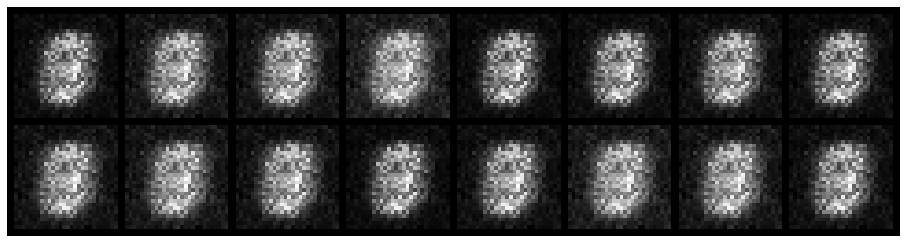

Epoch: [1/50], Batch Num: [500/600]
Discriminator Loss: 0.4839, Generator Loss: 2.0953
D(x): 0.7494, D(G(z)): 0.1427


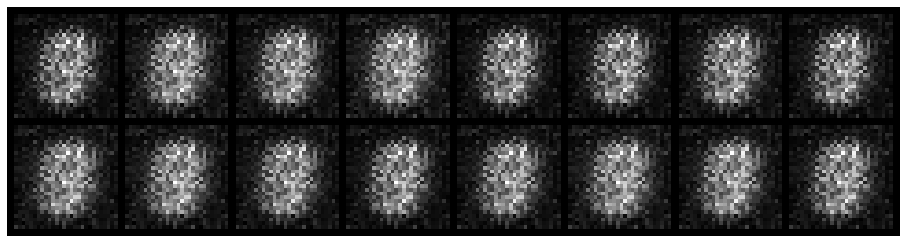

Epoch: [2/50], Batch Num: [0/600]
Discriminator Loss: 1.4127, Generator Loss: 1.4688
D(x): 0.6416, D(G(z)): 0.4381


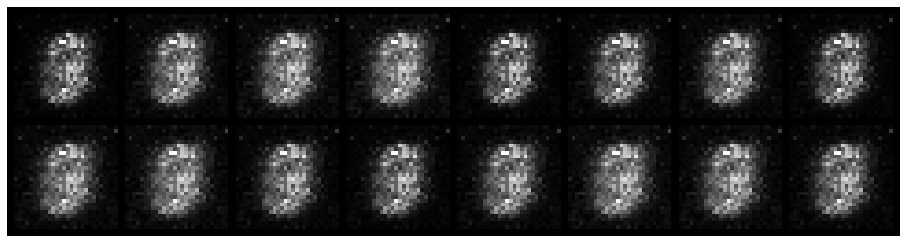

Epoch: [2/50], Batch Num: [100/600]
Discriminator Loss: 2.8699, Generator Loss: 0.3209
D(x): 0.4693, D(G(z)): 0.8272


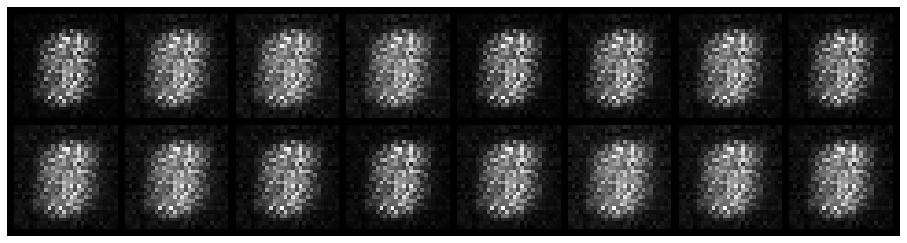

Epoch: [2/50], Batch Num: [200/600]
Discriminator Loss: 0.6950, Generator Loss: 1.4702
D(x): 0.8196, D(G(z)): 0.3418


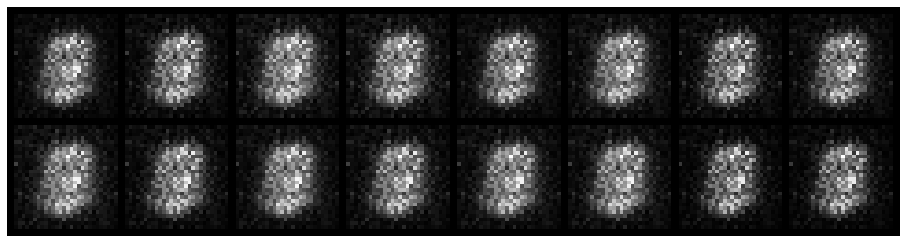

Epoch: [2/50], Batch Num: [300/600]
Discriminator Loss: 2.2204, Generator Loss: 0.5891
D(x): 0.4869, D(G(z)): 0.6696


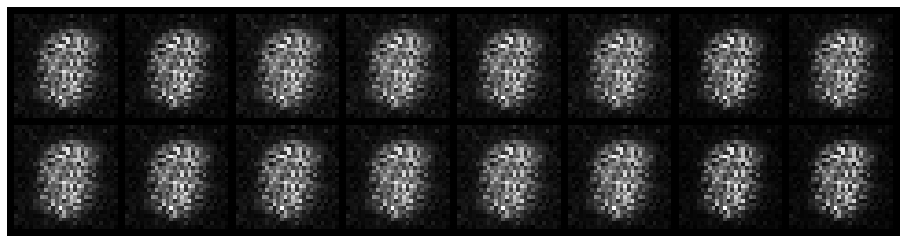

Epoch: [2/50], Batch Num: [400/600]
Discriminator Loss: 1.6292, Generator Loss: 1.9404
D(x): 0.7604, D(G(z)): 0.5779


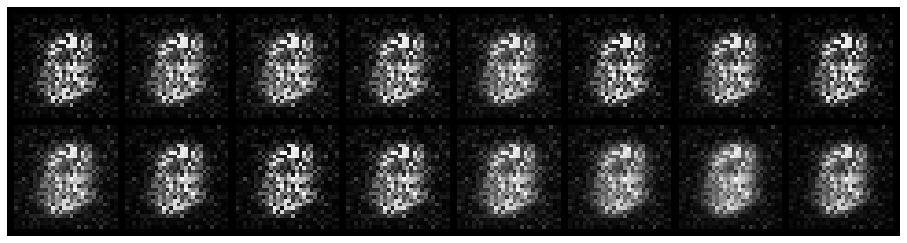

Epoch: [2/50], Batch Num: [500/600]
Discriminator Loss: 1.3893, Generator Loss: 1.0627
D(x): 0.6450, D(G(z)): 0.5160


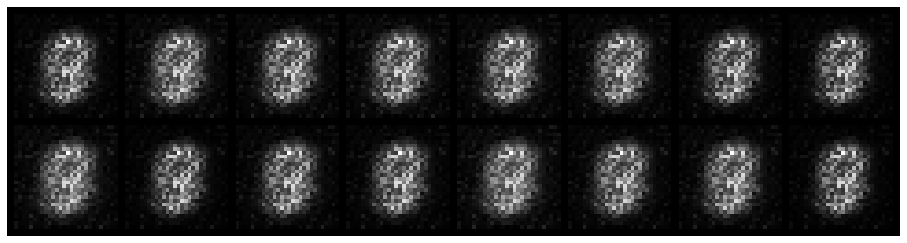

Epoch: [3/50], Batch Num: [0/600]
Discriminator Loss: 0.4273, Generator Loss: 2.3574
D(x): 0.8534, D(G(z)): 0.1723


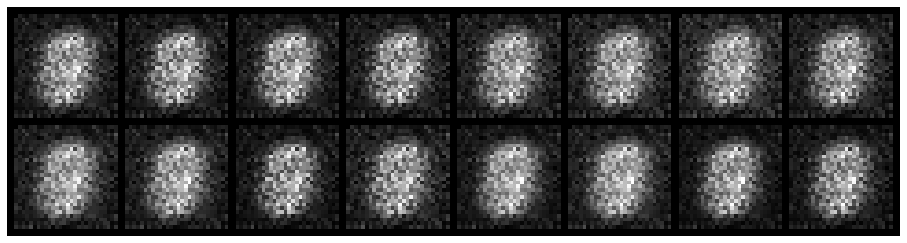

Epoch: [3/50], Batch Num: [100/600]
Discriminator Loss: 0.9021, Generator Loss: 0.9769
D(x): 0.8417, D(G(z)): 0.4446


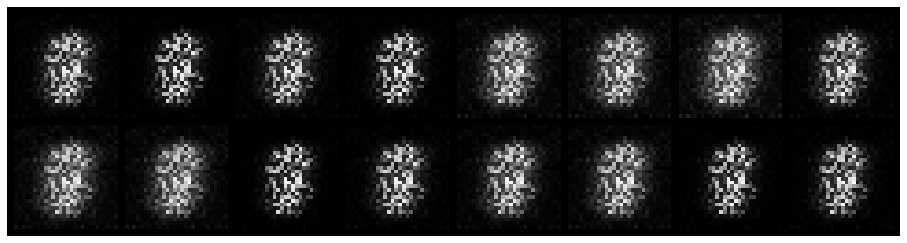

Epoch: [3/50], Batch Num: [200/600]
Discriminator Loss: 0.4270, Generator Loss: 2.8471
D(x): 0.8627, D(G(z)): 0.1693


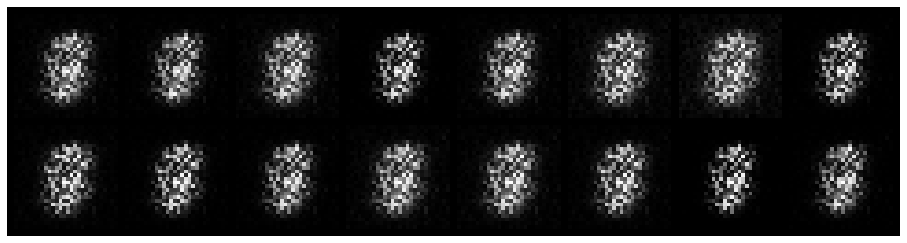

Epoch: [3/50], Batch Num: [300/600]
Discriminator Loss: 0.3214, Generator Loss: 2.8527
D(x): 0.8702, D(G(z)): 0.1102


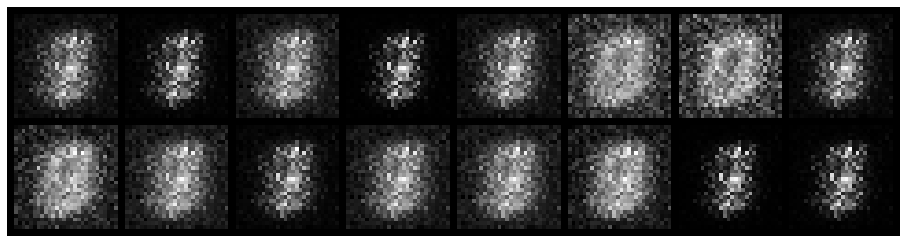

Epoch: [3/50], Batch Num: [400/600]
Discriminator Loss: 1.0257, Generator Loss: 1.7809
D(x): 0.7252, D(G(z)): 0.2853


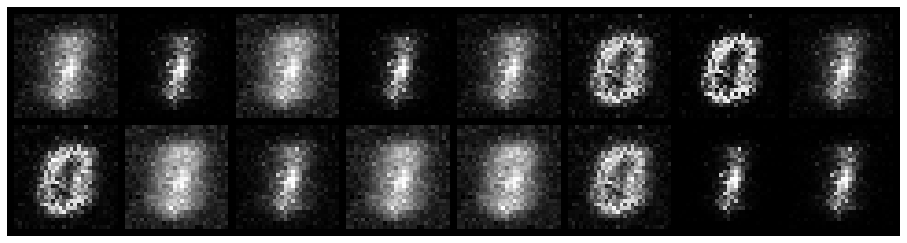

Epoch: [3/50], Batch Num: [500/600]
Discriminator Loss: 0.4908, Generator Loss: 2.4025
D(x): 0.8234, D(G(z)): 0.1623


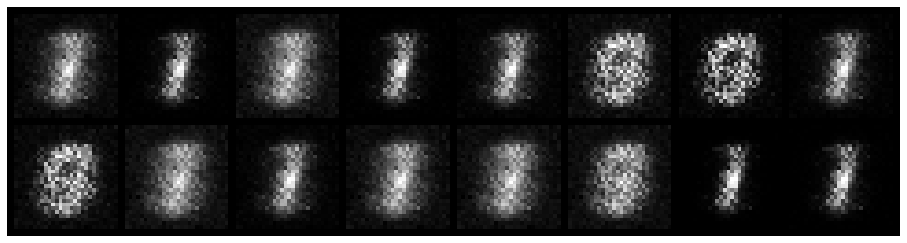

Epoch: [4/50], Batch Num: [0/600]
Discriminator Loss: 0.4461, Generator Loss: 2.2626
D(x): 0.8683, D(G(z)): 0.1915


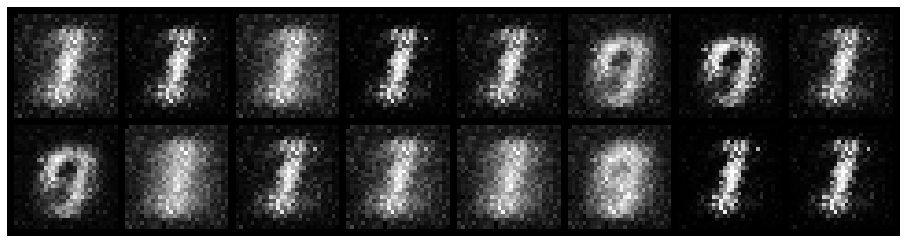

Epoch: [4/50], Batch Num: [100/600]
Discriminator Loss: 1.0892, Generator Loss: 1.3353
D(x): 0.7053, D(G(z)): 0.3378


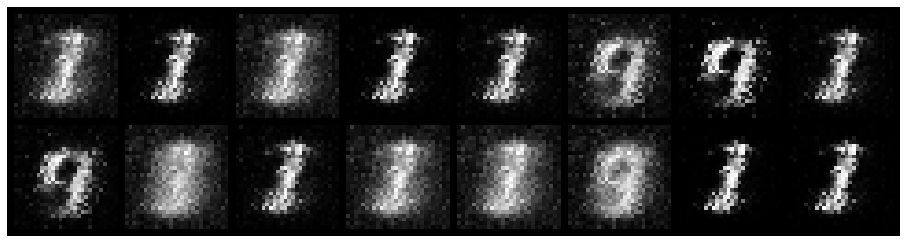

Epoch: [4/50], Batch Num: [200/600]
Discriminator Loss: 0.4491, Generator Loss: 2.7283
D(x): 0.8977, D(G(z)): 0.1677


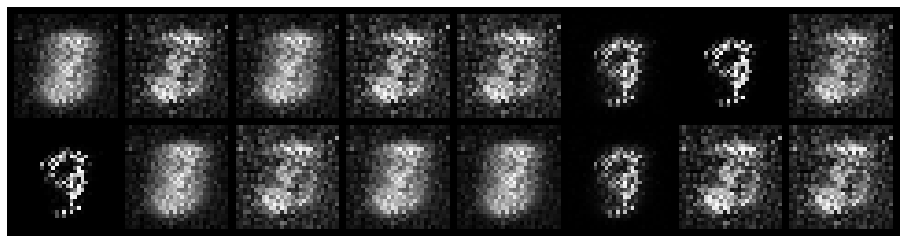

Epoch: [4/50], Batch Num: [300/600]
Discriminator Loss: 0.3561, Generator Loss: 2.5416
D(x): 0.9179, D(G(z)): 0.1768


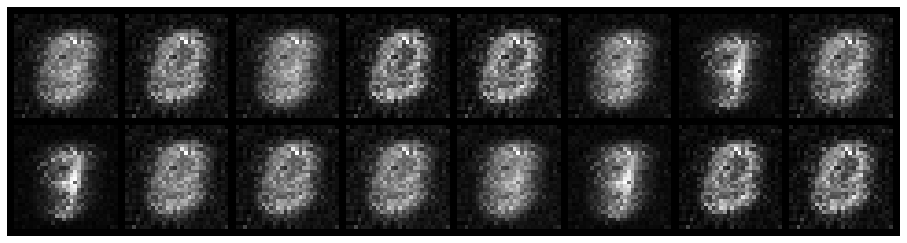

Epoch: [4/50], Batch Num: [400/600]
Discriminator Loss: 0.5435, Generator Loss: 1.9833
D(x): 0.8388, D(G(z)): 0.1923


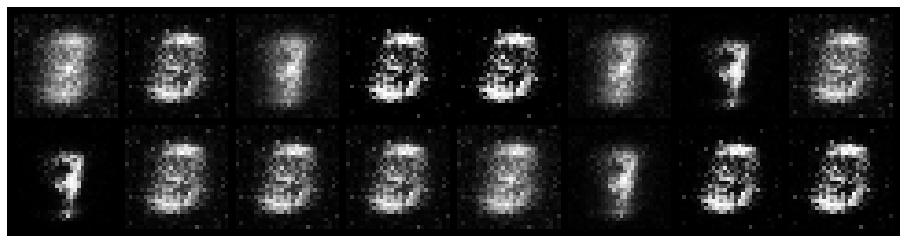

Epoch: [4/50], Batch Num: [500/600]
Discriminator Loss: 0.4750, Generator Loss: 2.2377
D(x): 0.8331, D(G(z)): 0.1498


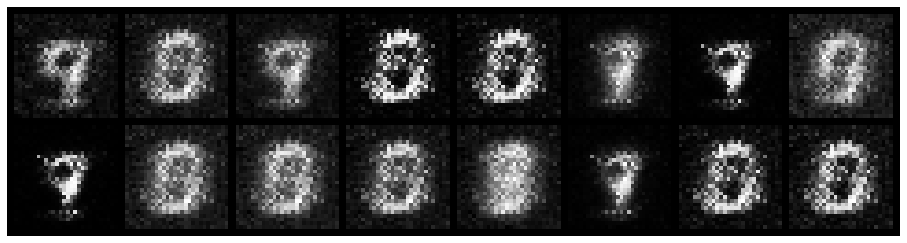

Epoch: [5/50], Batch Num: [0/600]
Discriminator Loss: 0.4287, Generator Loss: 3.2311
D(x): 0.8466, D(G(z)): 0.0645


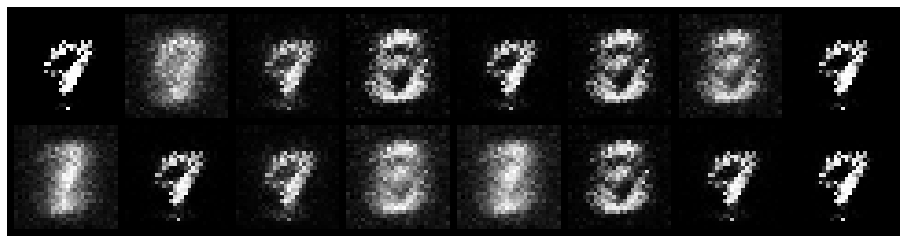

Epoch: [5/50], Batch Num: [100/600]
Discriminator Loss: 0.2924, Generator Loss: 3.0789
D(x): 0.9126, D(G(z)): 0.1143


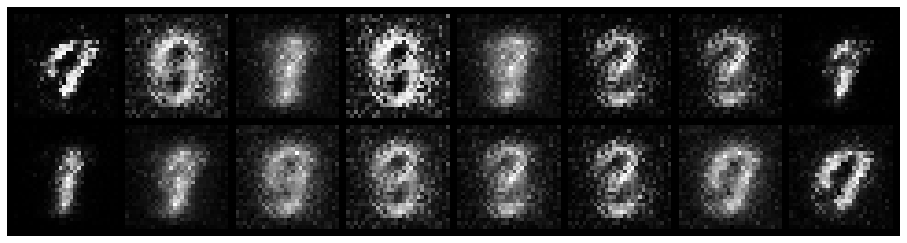

Epoch: [5/50], Batch Num: [200/600]
Discriminator Loss: 0.6747, Generator Loss: 2.5117
D(x): 0.8218, D(G(z)): 0.2201


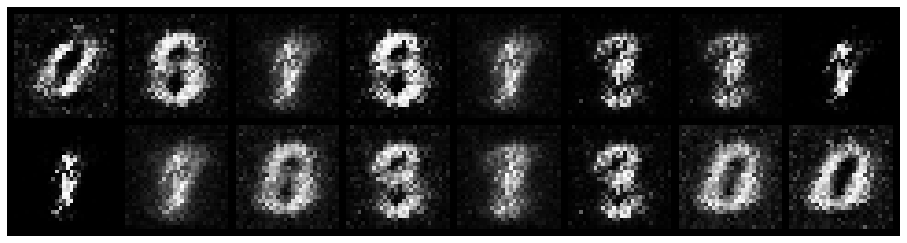

Epoch: [5/50], Batch Num: [300/600]
Discriminator Loss: 0.4098, Generator Loss: 3.2574
D(x): 0.8655, D(G(z)): 0.1035


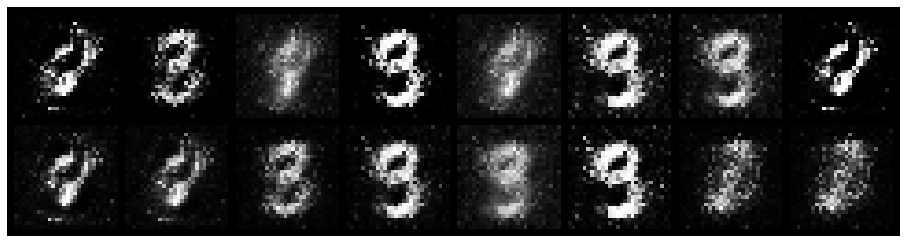

Epoch: [5/50], Batch Num: [400/600]
Discriminator Loss: 0.7472, Generator Loss: 2.0858
D(x): 0.7887, D(G(z)): 0.1670


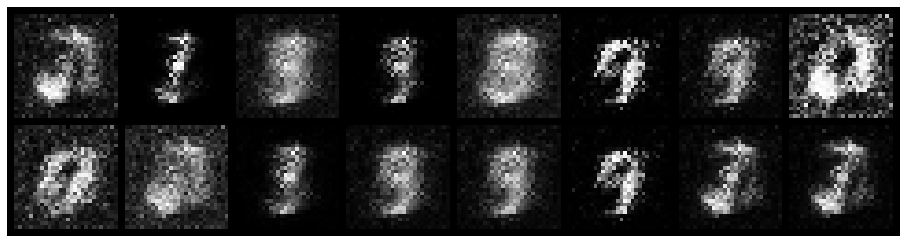

Epoch: [5/50], Batch Num: [500/600]
Discriminator Loss: 0.8416, Generator Loss: 1.9320
D(x): 0.7709, D(G(z)): 0.1973


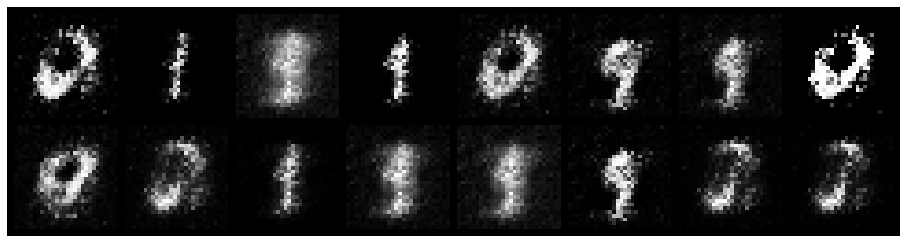

Epoch: [6/50], Batch Num: [0/600]
Discriminator Loss: 0.7306, Generator Loss: 2.6115
D(x): 0.8230, D(G(z)): 0.2356


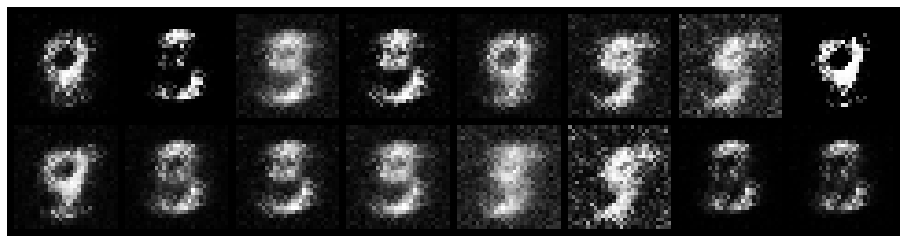

Epoch: [6/50], Batch Num: [100/600]
Discriminator Loss: 0.5552, Generator Loss: 2.8428
D(x): 0.7753, D(G(z)): 0.0806


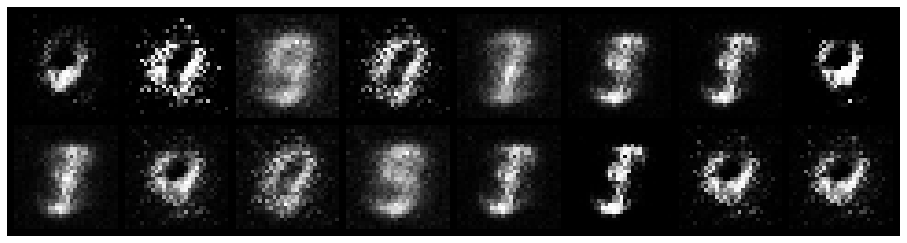

Epoch: [6/50], Batch Num: [200/600]
Discriminator Loss: 0.7874, Generator Loss: 2.0090
D(x): 0.7670, D(G(z)): 0.2466


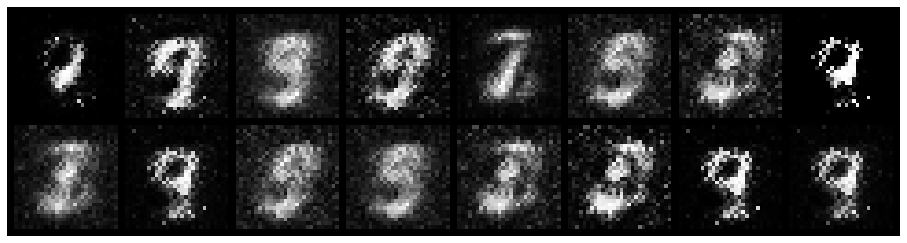

Epoch: [6/50], Batch Num: [300/600]
Discriminator Loss: 0.5135, Generator Loss: 2.4115
D(x): 0.8176, D(G(z)): 0.1512


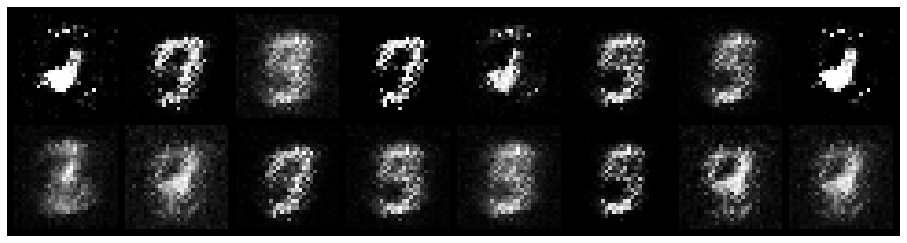

Epoch: [6/50], Batch Num: [400/600]
Discriminator Loss: 0.4420, Generator Loss: 3.3132
D(x): 0.8894, D(G(z)): 0.1571


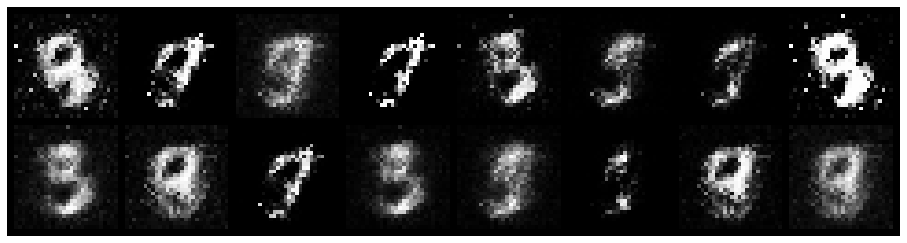

Epoch: [6/50], Batch Num: [500/600]
Discriminator Loss: 0.8540, Generator Loss: 1.8469
D(x): 0.7823, D(G(z)): 0.3099


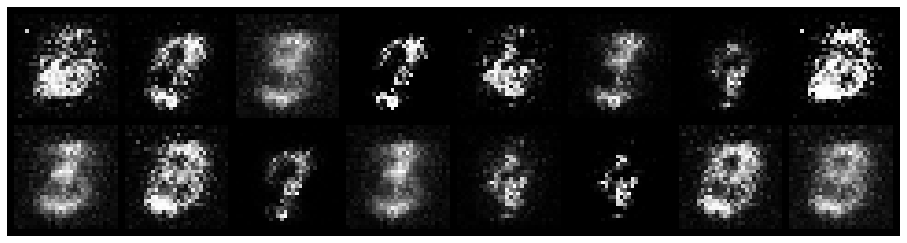

Epoch: [7/50], Batch Num: [0/600]
Discriminator Loss: 0.4984, Generator Loss: 2.3979
D(x): 0.8097, D(G(z)): 0.1396


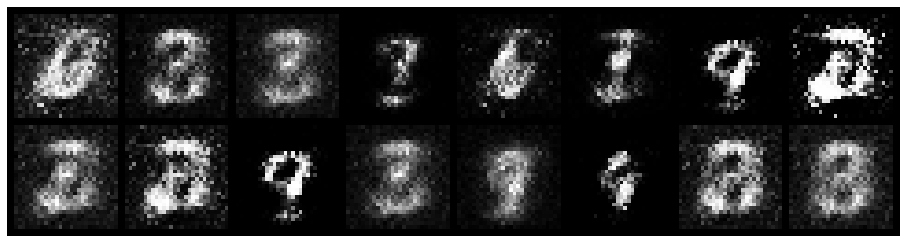

Epoch: [7/50], Batch Num: [100/600]
Discriminator Loss: 0.6110, Generator Loss: 2.3875
D(x): 0.8519, D(G(z)): 0.2403


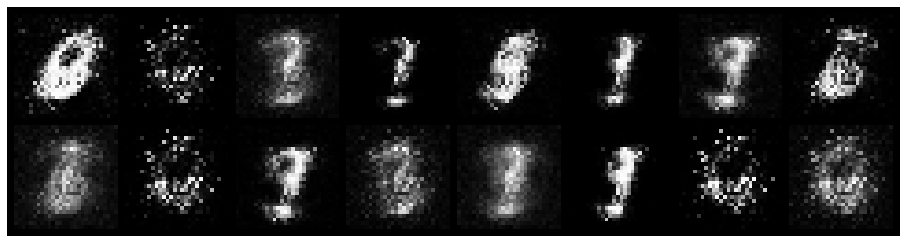

Epoch: [7/50], Batch Num: [200/600]
Discriminator Loss: 0.5237, Generator Loss: 1.6070
D(x): 0.8490, D(G(z)): 0.2553


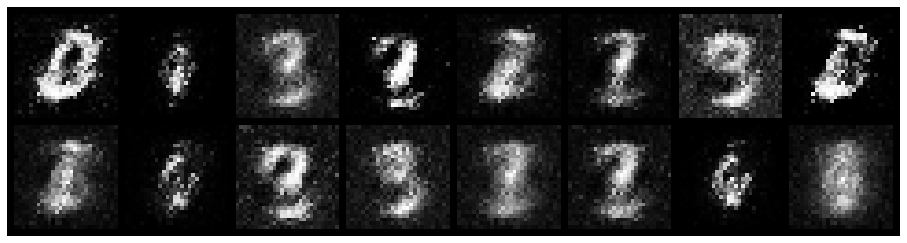

Epoch: [7/50], Batch Num: [300/600]
Discriminator Loss: 0.7102, Generator Loss: 1.9035
D(x): 0.8494, D(G(z)): 0.2810


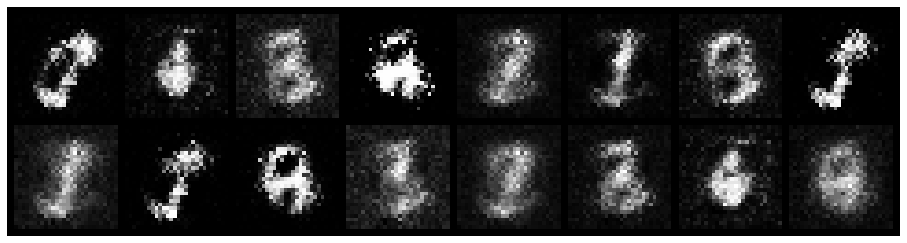

Epoch: [7/50], Batch Num: [400/600]
Discriminator Loss: 0.5622, Generator Loss: 1.9924
D(x): 0.7890, D(G(z)): 0.1678


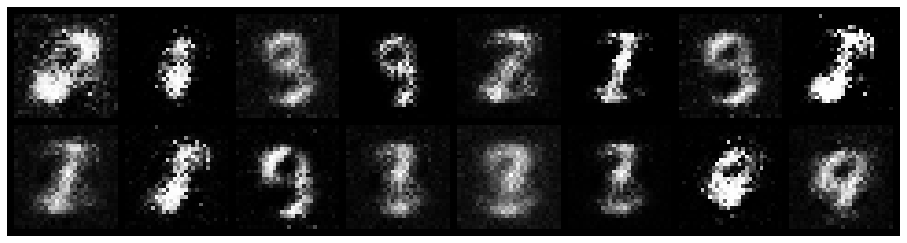

Epoch: [7/50], Batch Num: [500/600]
Discriminator Loss: 0.5820, Generator Loss: 2.2530
D(x): 0.7353, D(G(z)): 0.1345


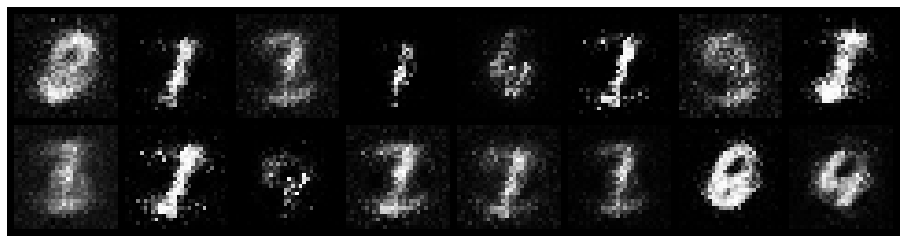

Epoch: [8/50], Batch Num: [0/600]
Discriminator Loss: 0.4960, Generator Loss: 2.7009
D(x): 0.8549, D(G(z)): 0.1876


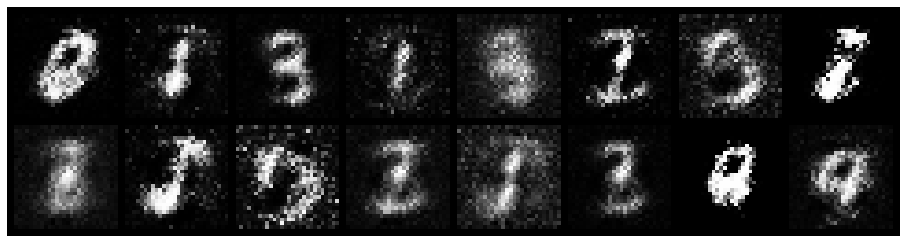

Epoch: [8/50], Batch Num: [100/600]
Discriminator Loss: 0.5093, Generator Loss: 2.6090
D(x): 0.8414, D(G(z)): 0.1480


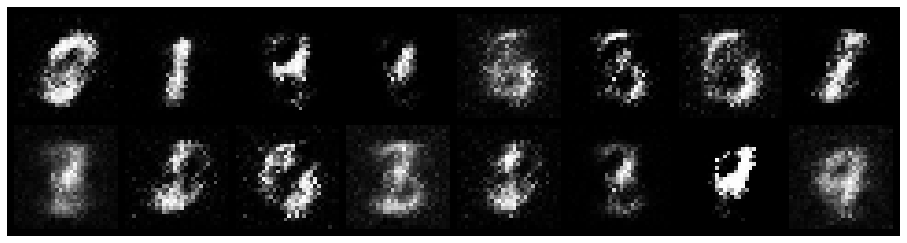

Epoch: [8/50], Batch Num: [200/600]
Discriminator Loss: 0.5182, Generator Loss: 2.8667
D(x): 0.8445, D(G(z)): 0.1401


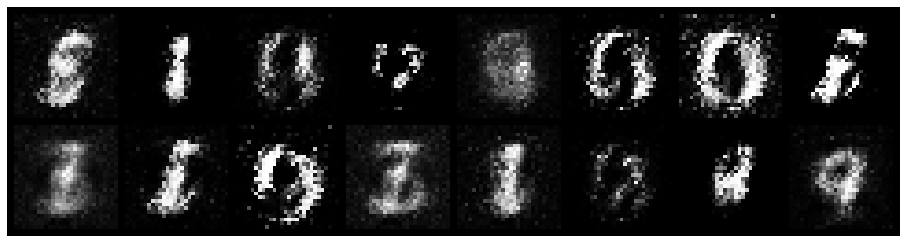

Epoch: [8/50], Batch Num: [300/600]
Discriminator Loss: 0.8079, Generator Loss: 1.9317
D(x): 0.7439, D(G(z)): 0.1824


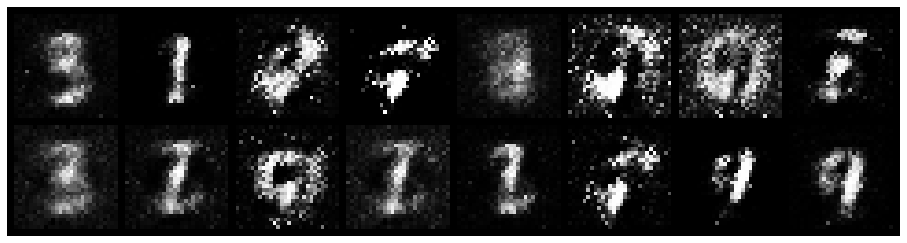

Epoch: [8/50], Batch Num: [400/600]
Discriminator Loss: 0.7802, Generator Loss: 2.4453
D(x): 0.7045, D(G(z)): 0.1305


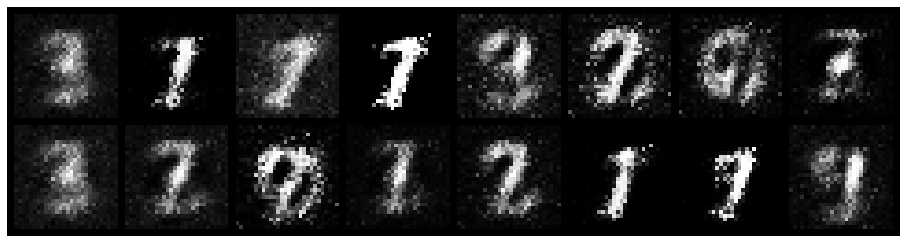

Epoch: [8/50], Batch Num: [500/600]
Discriminator Loss: 0.8336, Generator Loss: 2.4084
D(x): 0.7674, D(G(z)): 0.2146


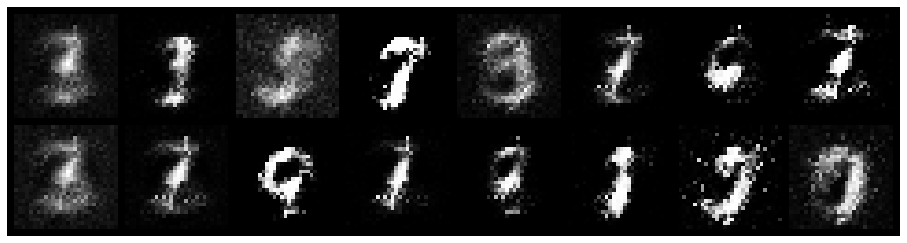

Epoch: [9/50], Batch Num: [0/600]
Discriminator Loss: 0.8802, Generator Loss: 1.8362
D(x): 0.7807, D(G(z)): 0.3049


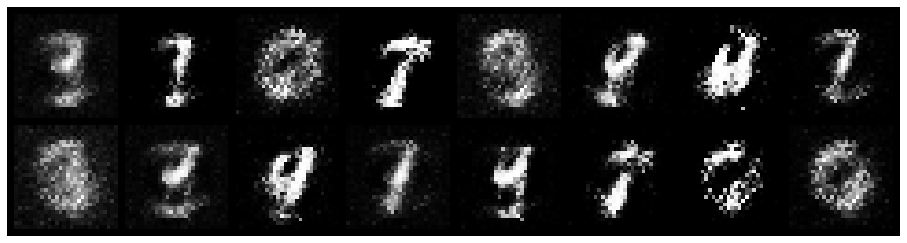

Epoch: [9/50], Batch Num: [100/600]
Discriminator Loss: 0.5418, Generator Loss: 3.1844
D(x): 0.8114, D(G(z)): 0.1470


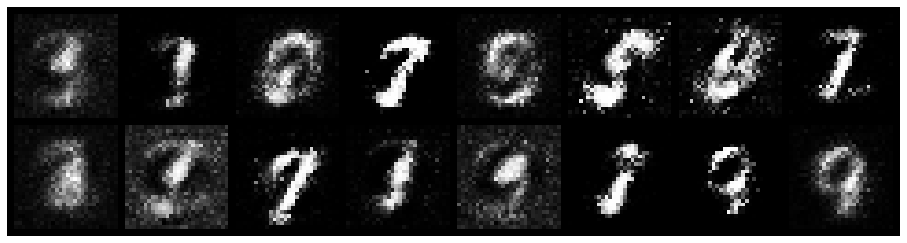

Epoch: [9/50], Batch Num: [200/600]
Discriminator Loss: 0.6327, Generator Loss: 2.1646
D(x): 0.9061, D(G(z)): 0.2731


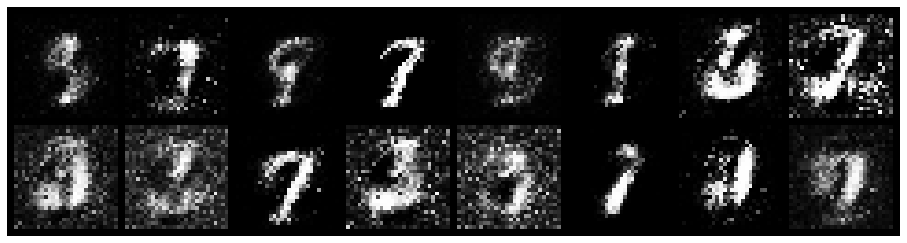

Epoch: [9/50], Batch Num: [300/600]
Discriminator Loss: 0.5545, Generator Loss: 2.4535
D(x): 0.7811, D(G(z)): 0.1680


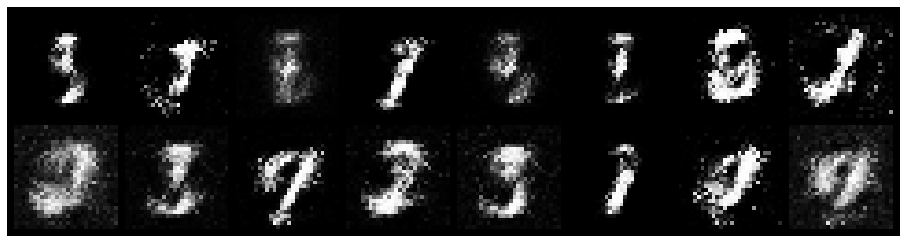

Epoch: [9/50], Batch Num: [400/600]
Discriminator Loss: 0.3508, Generator Loss: 2.1512
D(x): 0.8859, D(G(z)): 0.1560


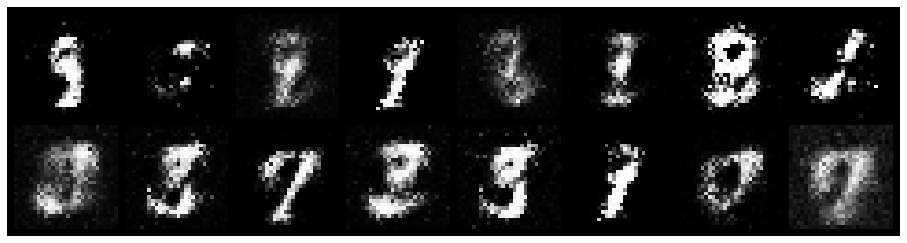

Epoch: [9/50], Batch Num: [500/600]
Discriminator Loss: 0.6605, Generator Loss: 2.0962
D(x): 0.7914, D(G(z)): 0.2107


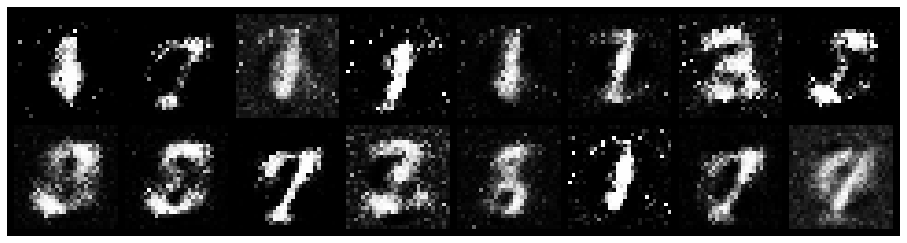

Epoch: [10/50], Batch Num: [0/600]
Discriminator Loss: 0.8742, Generator Loss: 2.0399
D(x): 0.6978, D(G(z)): 0.2353


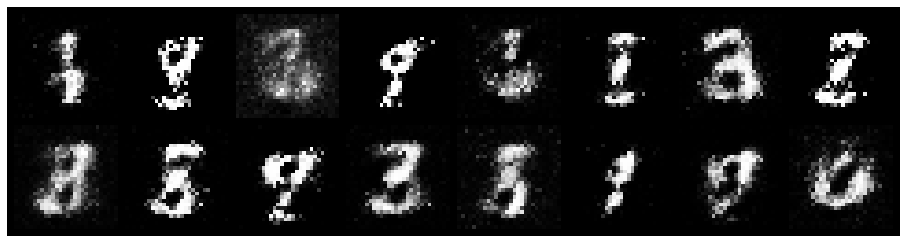

Epoch: [10/50], Batch Num: [100/600]
Discriminator Loss: 0.5098, Generator Loss: 3.1222
D(x): 0.8440, D(G(z)): 0.1434


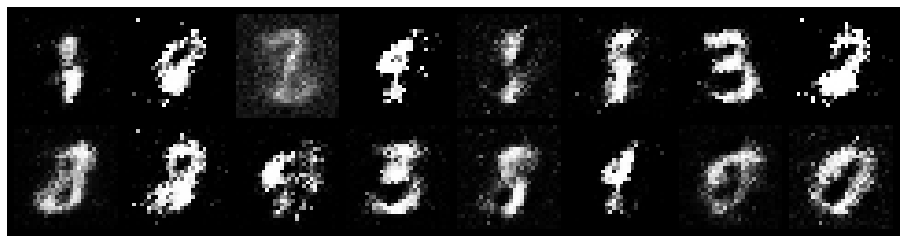

Epoch: [10/50], Batch Num: [200/600]
Discriminator Loss: 0.6478, Generator Loss: 2.0822
D(x): 0.8457, D(G(z)): 0.2843


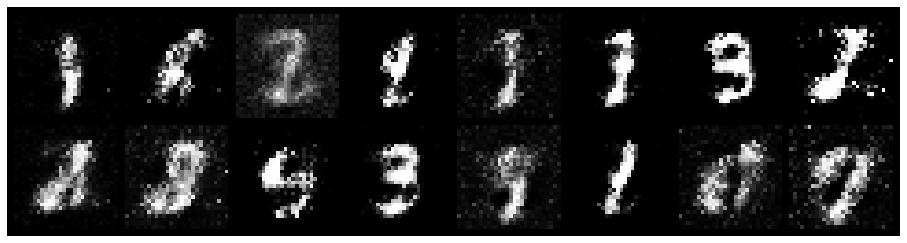

Epoch: [10/50], Batch Num: [300/600]
Discriminator Loss: 0.5510, Generator Loss: 2.4478
D(x): 0.8212, D(G(z)): 0.1759


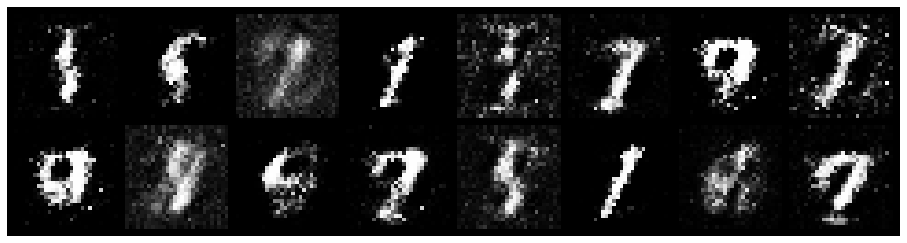

Epoch: [10/50], Batch Num: [400/600]
Discriminator Loss: 0.6031, Generator Loss: 2.6761
D(x): 0.7796, D(G(z)): 0.1614


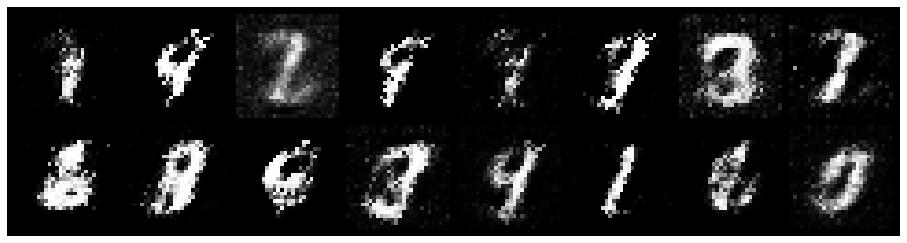

Epoch: [10/50], Batch Num: [500/600]
Discriminator Loss: 0.5598, Generator Loss: 2.6615
D(x): 0.8393, D(G(z)): 0.1741


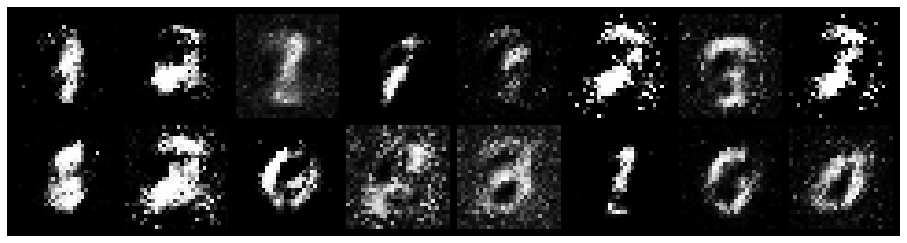

Epoch: [11/50], Batch Num: [0/600]
Discriminator Loss: 0.8792, Generator Loss: 1.7038
D(x): 0.6716, D(G(z)): 0.1607


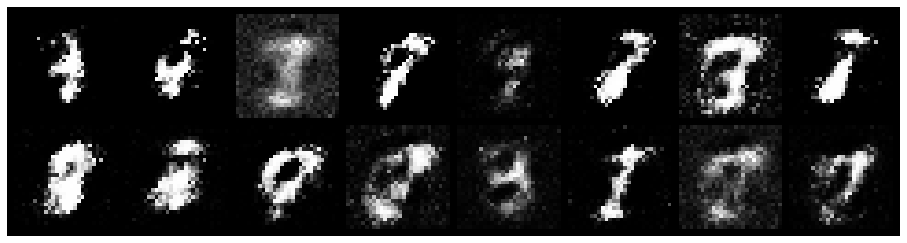

Epoch: [11/50], Batch Num: [100/600]
Discriminator Loss: 1.0109, Generator Loss: 2.1562
D(x): 0.7404, D(G(z)): 0.2533


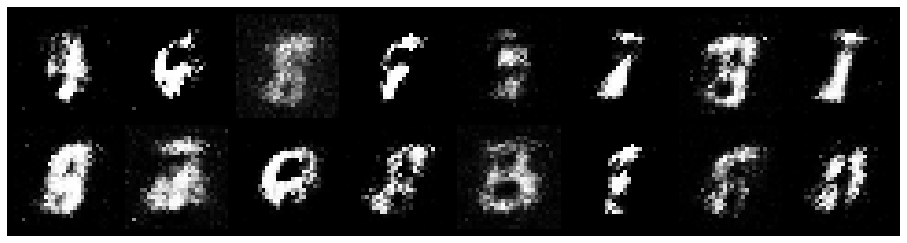

Epoch: [11/50], Batch Num: [200/600]
Discriminator Loss: 0.4797, Generator Loss: 2.7047
D(x): 0.8339, D(G(z)): 0.1355


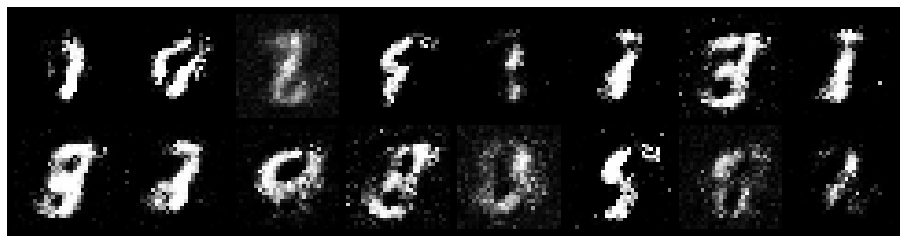

Epoch: [11/50], Batch Num: [300/600]
Discriminator Loss: 0.8389, Generator Loss: 2.6107
D(x): 0.7926, D(G(z)): 0.2785


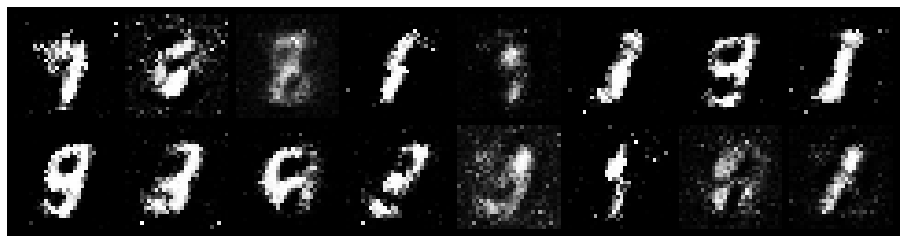

Epoch: [11/50], Batch Num: [400/600]
Discriminator Loss: 0.5725, Generator Loss: 2.8505
D(x): 0.8268, D(G(z)): 0.2017


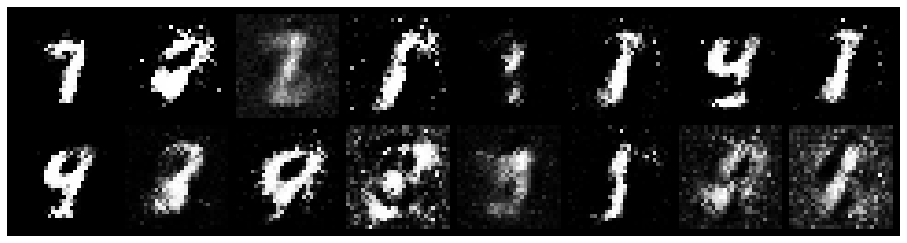

Epoch: [11/50], Batch Num: [500/600]
Discriminator Loss: 0.6708, Generator Loss: 2.5660
D(x): 0.7307, D(G(z)): 0.1260


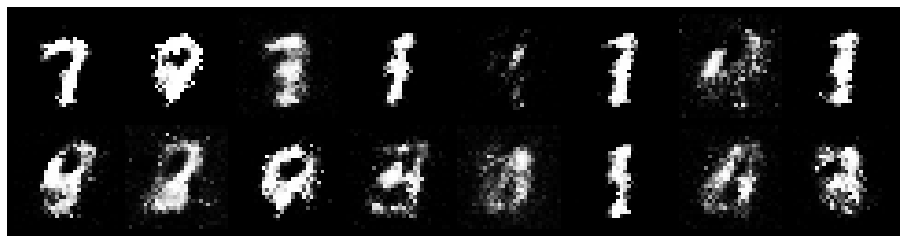

Epoch: [12/50], Batch Num: [0/600]
Discriminator Loss: 0.7358, Generator Loss: 1.8522
D(x): 0.8145, D(G(z)): 0.2731


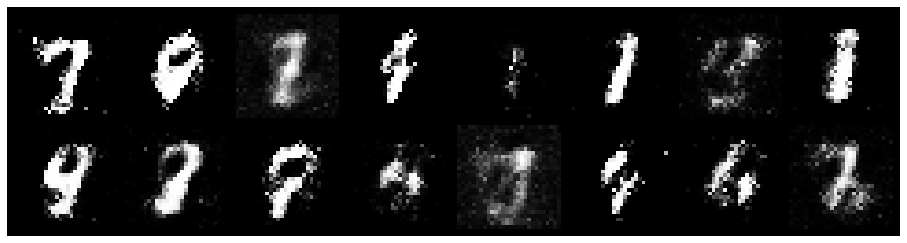

Epoch: [12/50], Batch Num: [100/600]
Discriminator Loss: 0.7520, Generator Loss: 2.1943
D(x): 0.7846, D(G(z)): 0.2345


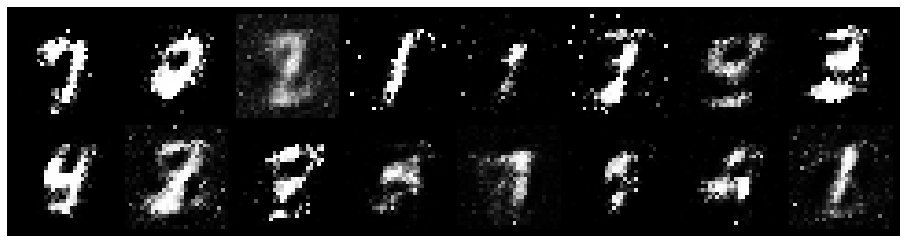

Epoch: [12/50], Batch Num: [200/600]
Discriminator Loss: 0.8113, Generator Loss: 1.4233
D(x): 0.7569, D(G(z)): 0.2826


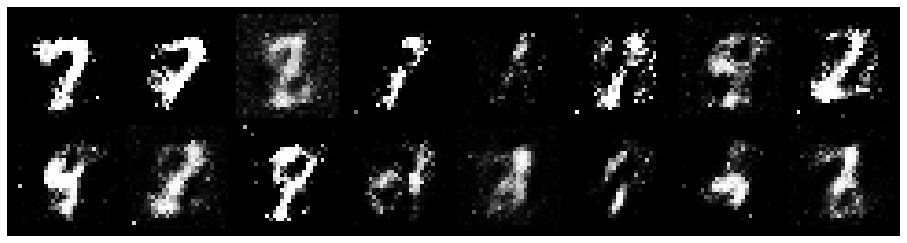

Epoch: [12/50], Batch Num: [300/600]
Discriminator Loss: 0.5255, Generator Loss: 2.2213
D(x): 0.8331, D(G(z)): 0.1895


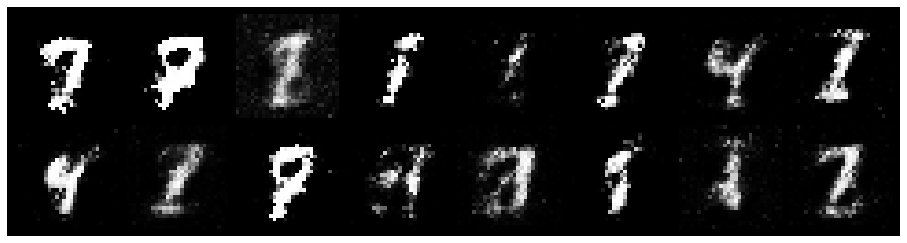

Epoch: [12/50], Batch Num: [400/600]
Discriminator Loss: 0.6422, Generator Loss: 2.0739
D(x): 0.7758, D(G(z)): 0.1765


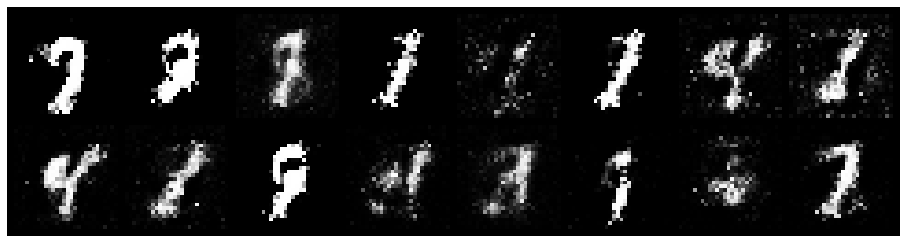

Epoch: [12/50], Batch Num: [500/600]
Discriminator Loss: 0.6757, Generator Loss: 2.5188
D(x): 0.8294, D(G(z)): 0.2330


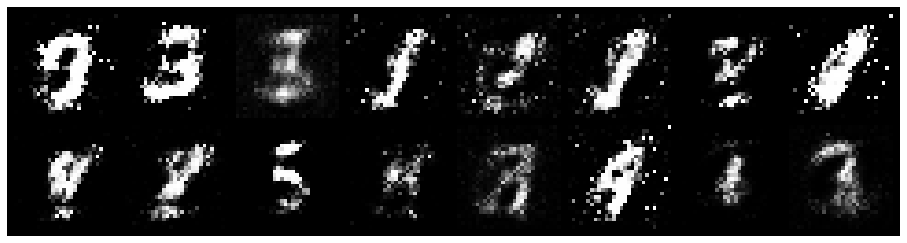

Epoch: [13/50], Batch Num: [0/600]
Discriminator Loss: 0.7866, Generator Loss: 2.1956
D(x): 0.8234, D(G(z)): 0.2647


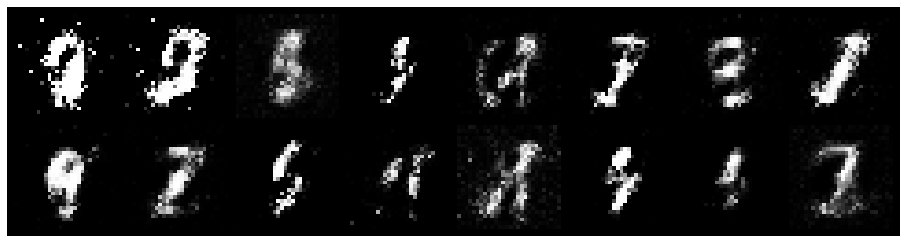

Epoch: [13/50], Batch Num: [100/600]
Discriminator Loss: 0.8829, Generator Loss: 1.7279
D(x): 0.7471, D(G(z)): 0.2684


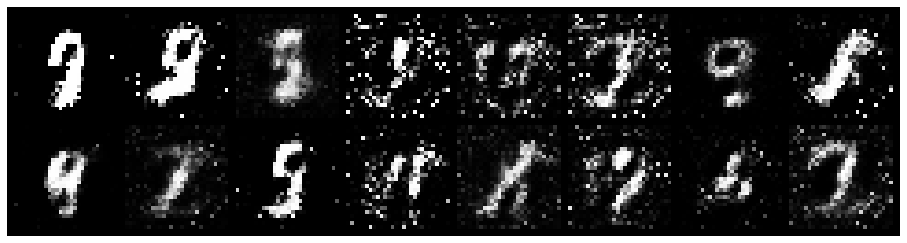

Epoch: [13/50], Batch Num: [200/600]
Discriminator Loss: 0.7626, Generator Loss: 2.1372
D(x): 0.7103, D(G(z)): 0.1658


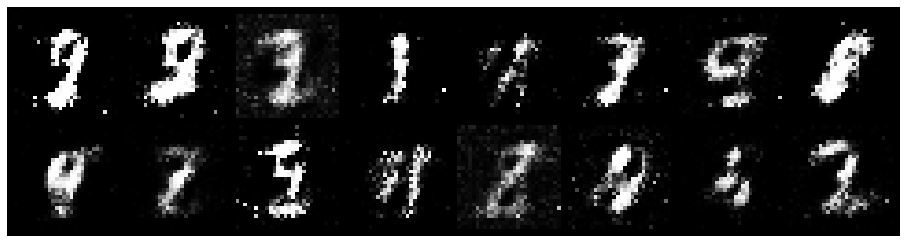

Epoch: [13/50], Batch Num: [300/600]
Discriminator Loss: 0.6880, Generator Loss: 3.2735
D(x): 0.7920, D(G(z)): 0.1967


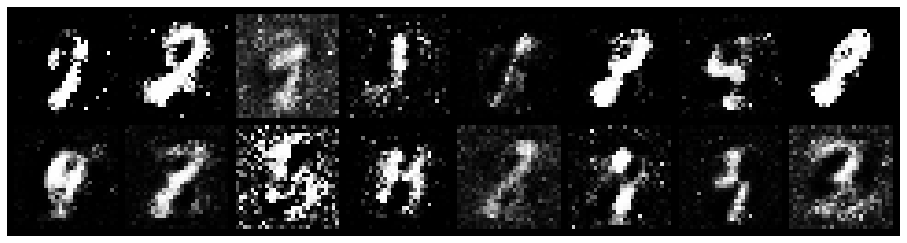

Epoch: [13/50], Batch Num: [400/600]
Discriminator Loss: 0.8907, Generator Loss: 1.7313
D(x): 0.7643, D(G(z)): 0.2825


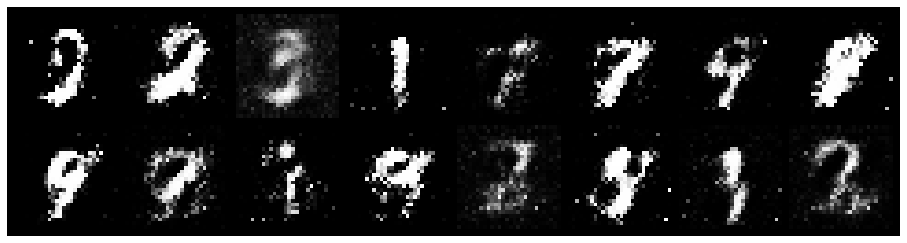

Epoch: [13/50], Batch Num: [500/600]
Discriminator Loss: 0.7962, Generator Loss: 1.8182
D(x): 0.7440, D(G(z)): 0.2375


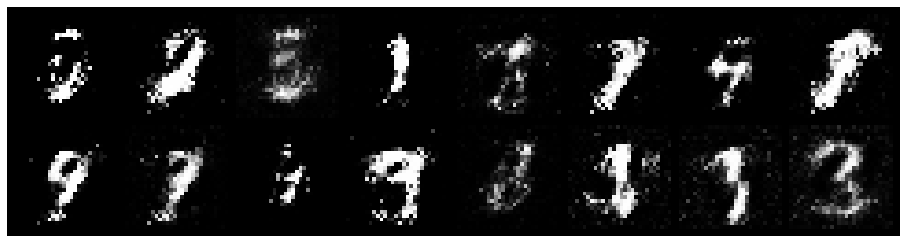

Epoch: [14/50], Batch Num: [0/600]
Discriminator Loss: 0.5247, Generator Loss: 2.3485
D(x): 0.7994, D(G(z)): 0.1515


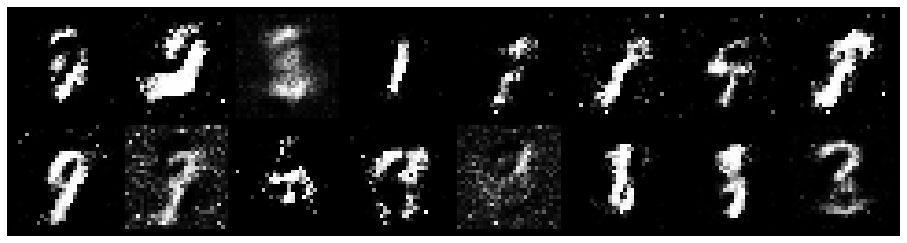

Epoch: [14/50], Batch Num: [100/600]
Discriminator Loss: 0.7777, Generator Loss: 1.6432
D(x): 0.8478, D(G(z)): 0.3465


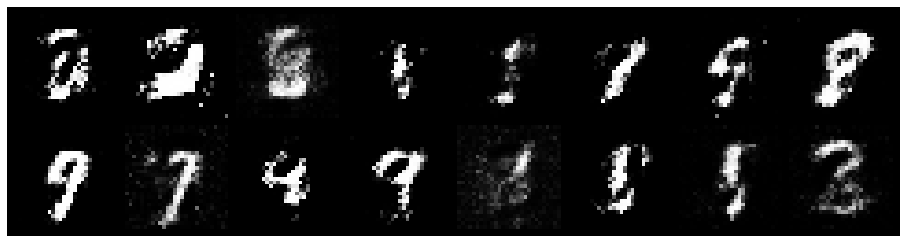

Epoch: [14/50], Batch Num: [200/600]
Discriminator Loss: 0.9791, Generator Loss: 1.7495
D(x): 0.6740, D(G(z)): 0.2675


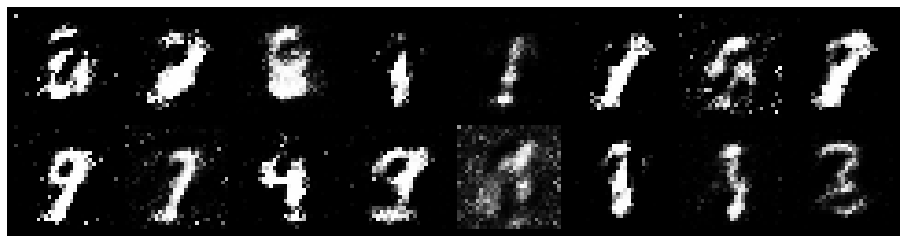

Epoch: [14/50], Batch Num: [300/600]
Discriminator Loss: 0.8124, Generator Loss: 2.4381
D(x): 0.6535, D(G(z)): 0.1339


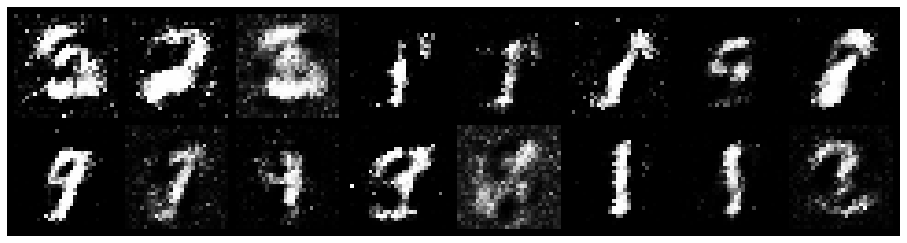

Epoch: [14/50], Batch Num: [400/600]
Discriminator Loss: 0.9903, Generator Loss: 1.7157
D(x): 0.7031, D(G(z)): 0.2891


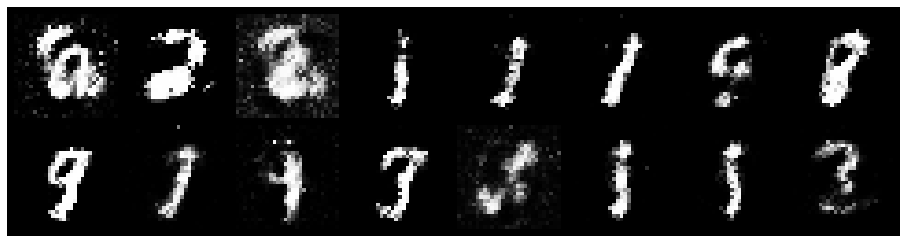

Epoch: [14/50], Batch Num: [500/600]
Discriminator Loss: 1.1307, Generator Loss: 1.3887
D(x): 0.6647, D(G(z)): 0.3083


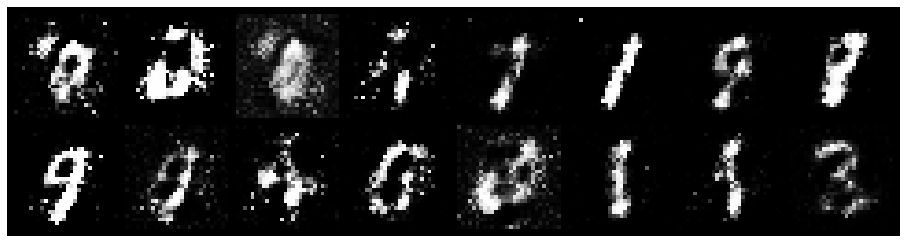

Epoch: [15/50], Batch Num: [0/600]
Discriminator Loss: 0.8376, Generator Loss: 1.5654
D(x): 0.7966, D(G(z)): 0.3185


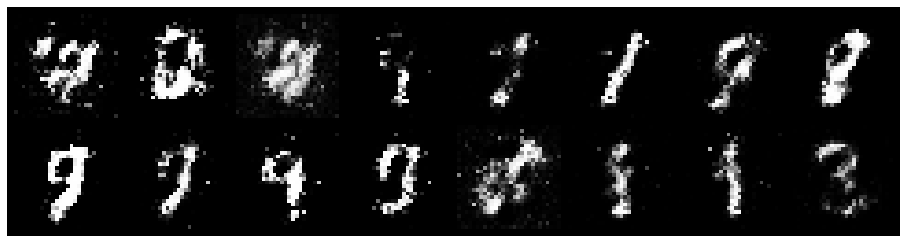

Epoch: [15/50], Batch Num: [100/600]
Discriminator Loss: 0.8046, Generator Loss: 1.6295
D(x): 0.7392, D(G(z)): 0.2773


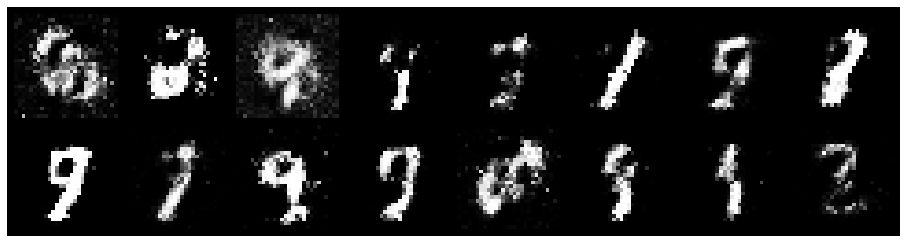

Epoch: [15/50], Batch Num: [200/600]
Discriminator Loss: 0.9410, Generator Loss: 1.4958
D(x): 0.7194, D(G(z)): 0.2881


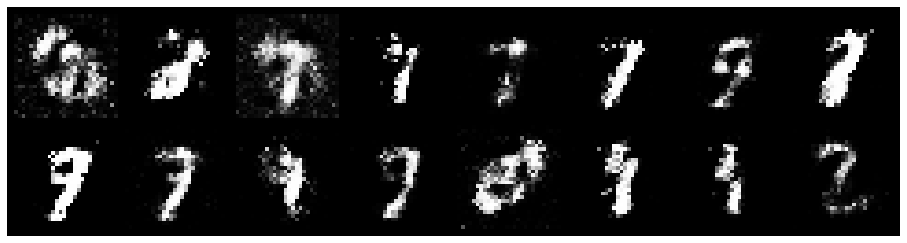

Epoch: [15/50], Batch Num: [300/600]
Discriminator Loss: 0.7918, Generator Loss: 1.9430
D(x): 0.7121, D(G(z)): 0.2078


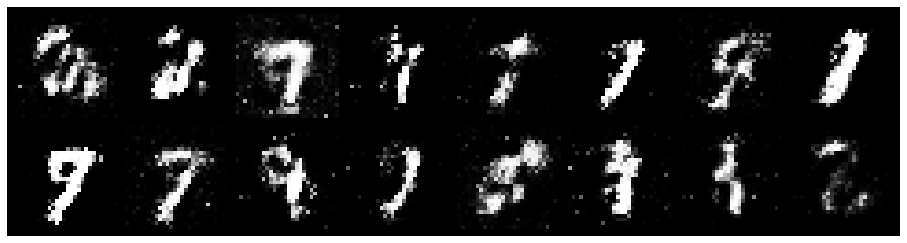

Epoch: [15/50], Batch Num: [400/600]
Discriminator Loss: 0.9594, Generator Loss: 1.7376
D(x): 0.7012, D(G(z)): 0.2780


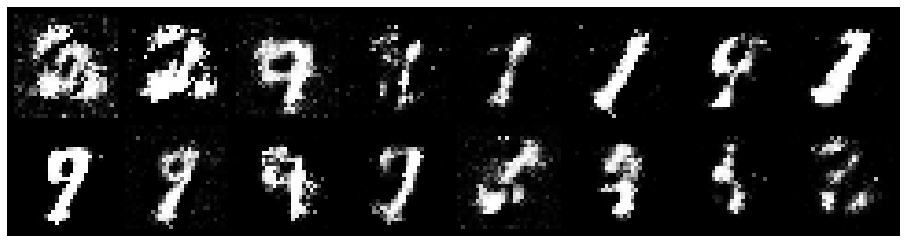

Epoch: [15/50], Batch Num: [500/600]
Discriminator Loss: 0.8558, Generator Loss: 1.3901
D(x): 0.7224, D(G(z)): 0.3054


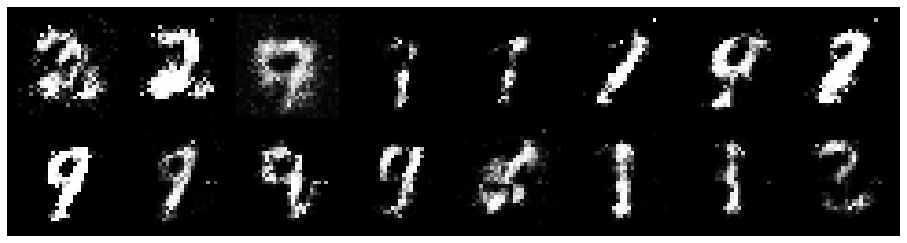

Epoch: [16/50], Batch Num: [0/600]
Discriminator Loss: 0.7887, Generator Loss: 1.3948
D(x): 0.6995, D(G(z)): 0.2712


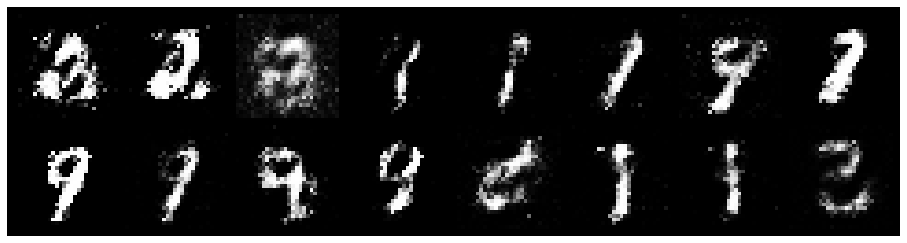

Epoch: [16/50], Batch Num: [100/600]
Discriminator Loss: 0.8512, Generator Loss: 1.8405
D(x): 0.7541, D(G(z)): 0.3020


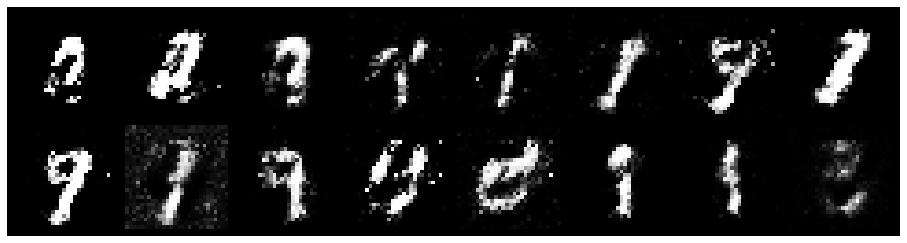

Epoch: [16/50], Batch Num: [200/600]
Discriminator Loss: 0.9052, Generator Loss: 1.7373
D(x): 0.6436, D(G(z)): 0.2058


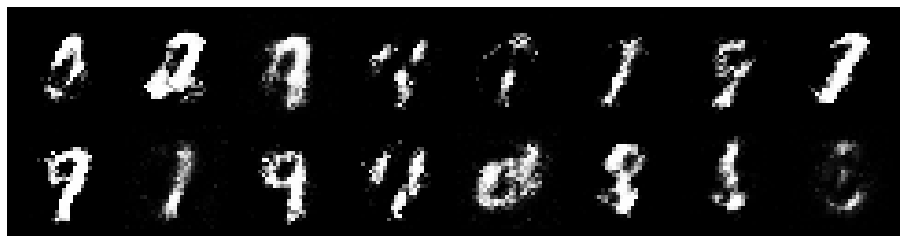

Epoch: [16/50], Batch Num: [300/600]
Discriminator Loss: 0.9519, Generator Loss: 1.6510
D(x): 0.7211, D(G(z)): 0.3262


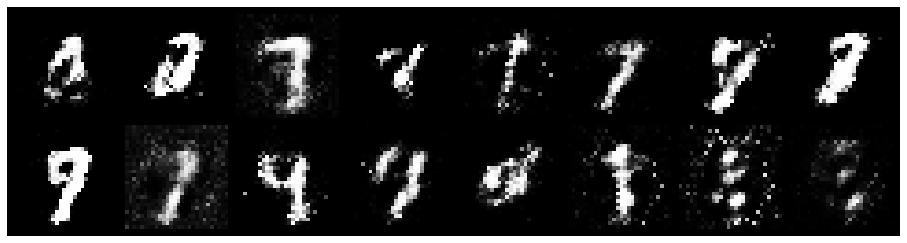

Epoch: [16/50], Batch Num: [400/600]
Discriminator Loss: 0.9887, Generator Loss: 1.1307
D(x): 0.6785, D(G(z)): 0.3430


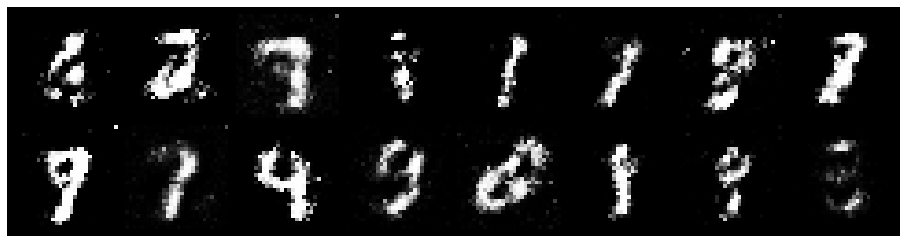

Epoch: [16/50], Batch Num: [500/600]
Discriminator Loss: 0.8679, Generator Loss: 1.7937
D(x): 0.6579, D(G(z)): 0.2120


KeyboardInterrupt: 

In [124]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')
# Total number of epochs to train
num_epochs = 50#200

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(image_loader):
        N = real_batch.size(0)
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N).to(device)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data.to(device), fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N).to(device))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data.to("cpu")
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )

In [125]:
test_images = vectors_to_images(generator(test_noise))

image = test_images.cpu().detach().numpy()
#plt.imshow(image[0][0], cmap='gray', interpolation='none')

## Resources

* https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f

## Notes

* NA

## ToDo

* Use conv2transpose for generator